In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('/content/Transactions Data.csv')

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179014 entries, 0 to 179013
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            179014 non-null  int64  
 1   type            179014 non-null  object 
 2   amount          179014 non-null  float64
 3   nameOrig        179013 non-null  object 
 4   oldbalanceOrg   179013 non-null  float64
 5   newbalanceOrig  179013 non-null  float64
 6   nameDest        179013 non-null  object 
 7   oldbalanceDest  179013 non-null  float64
 8   newbalanceDest  179013 non-null  float64
 9   isFraud         179013 non-null  float64
 10  isFlaggedFraud  179013 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 15.0+ MB


In [6]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,179014.000000,1.790140e+05,1.790130e+05,1.790130e+05,1.790130e+05,1.790130e+05,179013.000000,179013.0
mean,9.739222,1.801320e+05,8.915856e+05,9.089488e+05,9.272605e+05,1.188120e+06,0.000776,0.0
std,1.999448,3.335828e+05,2.814423e+06,2.851534e+06,2.374230e+06,2.676059e+06,0.027855,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,9.000000,1.166942e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,10.000000,6.566817e+04,1.976200e+04,0.000000e+00,4.233860e+04,1.163345e+05,0.000000,0.0
75%,11.000000,2.268392e+05,1.935541e+05,2.276798e+05,7.298561e+05,1.166438e+06,0.000000,0.0
max,12.000000,1.000000e+07,3.893942e+07,3.894623e+07,3.903958e+07,3.904248e+07,1.000000,0.0


In [7]:
missing_values=data.isnull().sum()
missing_values

,0
step,0
type,0
amount,0
nameOrig,1
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


In [11]:
data.fillna({
    'nameOrig': data['nameOrig'].mode()[0],
    'nameDest': data['nameDest'].mode()[0],
    'oldbalanceOrg': data['oldbalanceOrg'].median(),
    'newbalanceOrig': data['newbalanceOrig'].median(),
    'oldbalanceDest': data['oldbalanceDest'].median(),
    'newbalanceDest': data['newbalanceDest'].median(),
    'isFraud': data['isFraud'].median(),
    'isFlaggedFraud': data['isFlaggedFraud'].median()
}, inplace=True)

data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [9]:
data['isFraud'] = data['isFraud'].astype(int)
data['isFlaggedFraud'] = data['isFlaggedFraud'].astype(int)

In [10]:
print(f"Duplicate Rows: {data.duplicated().sum()}")

Duplicate Rows: 0


In [12]:
le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])

In [13]:
data['balanceChange'] = data['newbalanceOrig'] - data['oldbalanceOrg']

In [14]:
X = data.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])
y = data['isFraud']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

In [17]:
# Model Training with Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in cv.split(X_train_res, y_train_res):
    X_cv_train, X_cv_val = X_train_res.iloc[train_idx], X_train_res.iloc[val_idx]
    y_cv_train, y_cv_val = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    model.fit(X_cv_train, y_cv_train)

    # Performance Metrics
    y_val_pred = model.predict(X_cv_val)
    print("Fold Accuracy:", accuracy_score(y_cv_val, y_val_pred))
    print("Fold F1-Score:", f1_score(y_cv_val, y_val_pred))
    print("Fold AUC:", roc_auc_score(y_cv_val, model.predict_proba(X_cv_val)[:, 1]))

Fold Accuracy: 0.9995632348573525
Fold F1-Score: 0.9995633874150789
Fold AUC: 0.999997761501384
Fold Accuracy: 0.9992837051660581
Fold F1-Score: 0.9992841053936548
Fold AUC: 0.9999969813537888
Fold Accuracy: 0.9992138227432346
Fold F1-Score: 0.9992142620174259
Fold AUC: 0.9999968958916109
Fold Accuracy: 0.9993885288002935
Fold F1-Score: 0.9993887637309862
Fold AUC: 0.9999985990307271
Fold Accuracy: 0.9994933435829344
Fold F1-Score: 0.9994935824674758
Fold AUC: 0.9999985006968359


In [18]:
# Evaluate on Test Data
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.9989665670474541
Test F1-Score: 0.463768115942029
Test AUC: 0.9751199060875398
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35778
           1       0.36      0.64      0.46        25

    accuracy                           1.00     35803
   macro avg       0.68      0.82      0.73     35803
weighted avg       1.00      1.00      1.00     35803



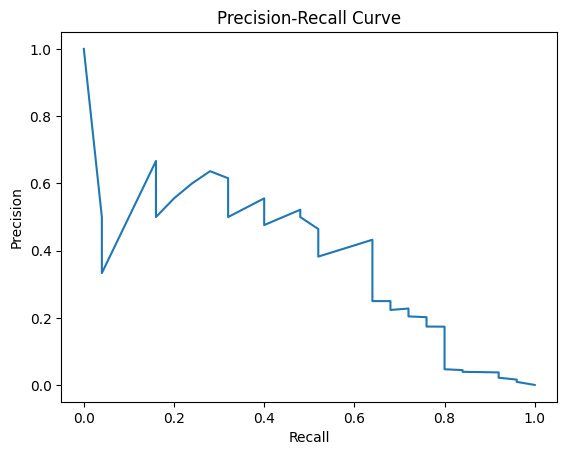

In [19]:
# Model Interpretation: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

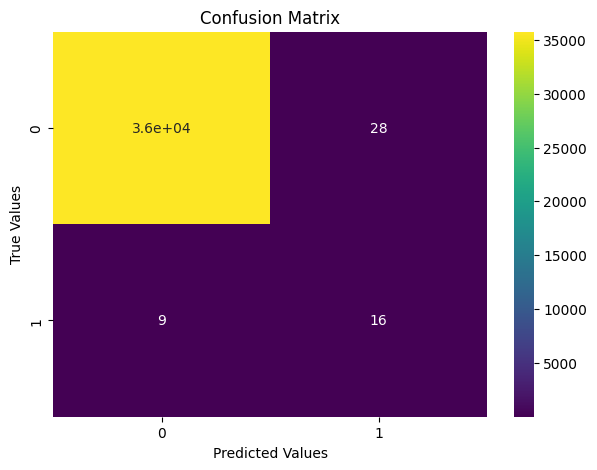

In [20]:
# Model Validation: Confusion Matrix Heatmap
confusion = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(confusion, annot=True, cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

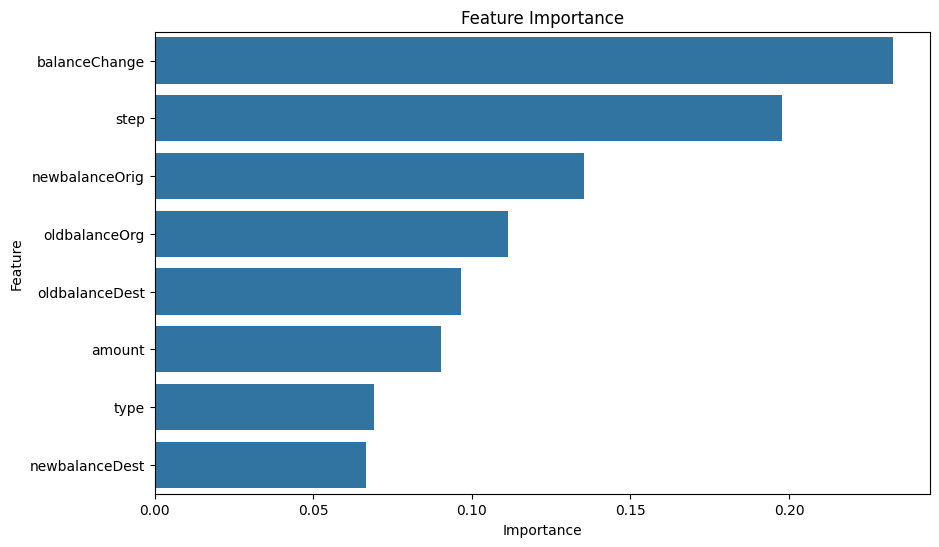

In [22]:
# Model Interpretation
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()
